## k-Nearest Neighbor Classifier

This notebook contains the code for the kNN classifier, which is 'trained' with a transformed dataset based on the feature 'f_3' in the lecture notes.

In [1]:
# Imported libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import block_diag

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
# Loading in raw image files, which are encoded as row-vectors.
mfeat_pix = np.loadtxt("./mfeat-pix.txt")

# Splitting the data into a training and testing dataset.
trainPatterns = np.concatenate((mfeat_pix[0:100], mfeat_pix[200:300], 
                               mfeat_pix[400:500], mfeat_pix[600:700],
                               mfeat_pix[800:900], mfeat_pix[1000:1100],
                               mfeat_pix[1200:1300], mfeat_pix[1400:1500],
                               mfeat_pix[1600:1700], mfeat_pix[1800:1900]))

testPatterns = np.concatenate((mfeat_pix[100:200], mfeat_pix[300:400], 
                               mfeat_pix[500:600], mfeat_pix[700:800],
                               mfeat_pix[900:1000], mfeat_pix[1100:1200],
                               mfeat_pix[1300:1400], mfeat_pix[1500:1600],
                               mfeat_pix[1700:1800], mfeat_pix[1900:2000]))

# Create indicator matrices size 10 x 1000 with the class labels coded by 
# binary indicator vectors.
b = np.array([1]*100)

# Create a row vector of correct class labels (from 0 ... 9 for the 10
# classes). This vector is the same for training and testing.
correctLabels = np.concatenate((b*0, b, b*2, b*3, b*4, b*5, b*6, b*7, b*8, b*9))

In [3]:
# From here, a demo implementation of a linear classifer based on 
# the ten class-mean features (hand-made features f_3 from the lecture notes, i.e. 'prototype matching').

meanTrainImages = np.zeros((240, 10))
for i in range(0, 10):
    meanTrainImages[:, i] = np.mean(trainPatterns[i*100:(i+1)*100, :], axis=0).T

featureValuesTrain = (meanTrainImages.T @ trainPatterns.T).T
featureValuesTest = (meanTrainImages.T @ testPatterns.T).T

In [4]:
# Defining some useful function(s).

def convert_to_images(data, indices, shape=(15, 16)):
    
    images = []
    for i in indices:
        pic = data[i]
        picmatreverse = np.zeros(shape)
        picmatreverse = -np.reshape(pic, (shape[1], shape[0])).T
        picmat = np.zeros(shape)
        for k in range(0, shape[0]):
            picmat[:, k] = picmatreverse[:, shape[0]-k]
        images.append(picmat.T)
        
    return images

def plot_images(images, indices, rows=5, columns=10, figsize=(15, 15)):
    figs, subplots = plt.subplots(rows, columns, sharex=True, sharey=True, figsize=figsize)
    
    for i in range(0, rows):
        for j in range(0, columns):
            subplots[i, j].pcolor(images[i*columns+j], cmap="gray")
            correctLabel = correctLabels[indices[i*columns+j]] 
            assignedLabel = labels_pred[indices[i*columns+j]]
            subplots[i, j].set_title("C: {}; A: {}".format(correctLabel, assignedLabel))

    plt.show()

## Grid search with kNN: 5-fold Cross-Validation

In [5]:
# kNN classifier:
# 'n_neighbors': number of neighbors
# 'distance': "weight points by the inverse of their distance. In this case, closer neighbors of a query point will 
#              have a greater influence than neighbors which are further away"
# algorithm: 'brute' (i.e., brute-force search)?

from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='brute', p=2, metric='minkowski')   
# Dictionary containing the parameter values that we want to test.
param_grid = {'n_neighbors': np.arange(1, 15, 1), 'p': [1, 2, 3]}
# Testing all values for n_neighbors and p with grid search.
knn_gscv = GridSearchCV(knn, param_grid, cv=5)
# Fitting model to data.
knn_gscv.fit(featureValuesTrain, correctLabels)

GridSearchCV(cv=5,
             estimator=KNeighborsClassifier(algorithm='brute',
                                            weights='distance'),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'p': [1, 2, 3]})

In [6]:
print("The best (mean) accuracy is {}% for {} as the input parameters.".format(knn_gscv.best_score_*100, knn_gscv.best_params_))

The best (mean) accuracy is 92.6% for {'n_neighbors': 3, 'p': 3} as the input parameters.


## kNN Classifier

In [7]:
# Based on the grid search results from the previous, we can set-up the 'best performing' kNN classifier.

knn_clf = KNeighborsClassifier(n_neighbors=3, weights='distance', algorithm='brute', p=3, metric='minkowski')  

Accuracy on test data: 91.40


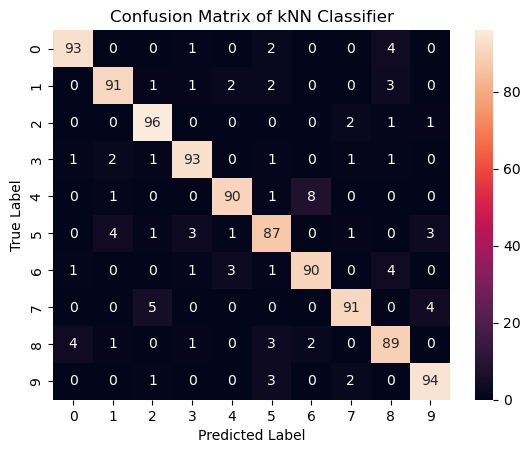

In [8]:
# Fitting 'best performing' model to training set.
model = knn_clf.fit(featureValuesTrain, correctLabels)
labels_pred = model.predict(featureValuesTest)

# Accuracy score
accuracy = accuracy_score(correctLabels, labels_pred)
print("Accuracy on test data: {:.2f}".format(accuracy*100))

# Confusion matrix
conf_mat = confusion_matrix(correctLabels, labels_pred)

# Plotting the confusion matrix of the kNN classifier.
image = sns.heatmap(conf_mat, annot=True, 
                    #cmap='Blues', 
                    fmt='g')
plt.title("Confusion Matrix of kNN Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Plotting Some Misclassified Test Images

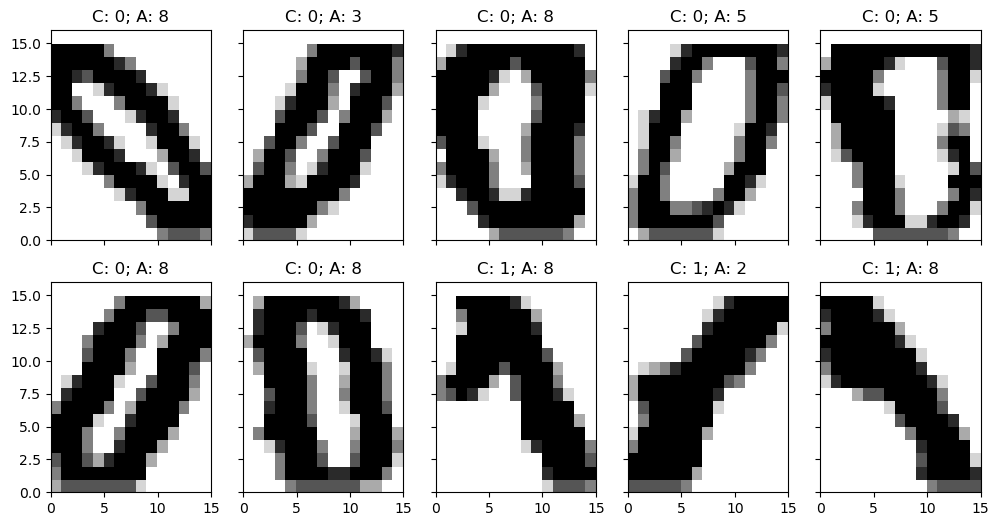

In [9]:
indMisclassifiedTest = np.where(correctLabels != labels_pred)[0]

imagesMisclassifiedTest = convert_to_images(testPatterns, indMisclassifiedTest)

plot_images(imagesMisclassifiedTest, indMisclassifiedTest, rows=2, columns=5, figsize=(12, 6))